In [1]:
'''
configurations of the network
    
    readout: G_ER_L_S = [1024+300+16+300+1024,  1024, 117]

    node_func: G_N_L_S = [1024+1024, 1024]
    node_lang_func: G_N_L_S2 = [300+300+300]
    
    edge_func : G_E_L_S = [1024*2+16, 1024]
    edge_lang_func: [300*2, 1024]
    
    attn: [1024, 1]
    attn_lang: [1024, 1]
'''

class CONFIGURATION(object):
    '''
    Configuration arguments: feature type, layer, bias, batch normalization, dropout, multi-attn
    
    readout           : fc_size, activation, bias, bn, droupout
    gnn_node          : fc_size, activation, bias, bn, droupout
    gnn_node_for_lang : fc_size, activation, bias, bn, droupout
    gnn_edge          : fc_size, activation, bias, bn, droupout
    gnn_edge_for_lang : fc_size, activation, bias, bn, droupout
    gnn_attn          : fc_size, activation, bias, bn, droupout
    gnn_attn_for_lang : fc_size, activation, bias, bn, droupout
    '''
    def __init__(self, layer=1, bias=True, bn=False, dropout=0.2, multi_attn=False):
        
        # if multi_attn:
        if True:
            if layer==1:
                feature_size = 512
                # readout
                self.G_ER_L_S = [feature_size+300+16+300+feature_size, feature_size, 13]
                self.G_ER_A   = ['ReLU', 'Identity']
                self.G_ER_B   = bias    #true
                self.G_ER_BN  = bn      #false
                self.G_ER_D   = dropout #0.3
                # self.G_ER_GRU = feature_size

                # # gnn node function
                self.G_N_L_S = [feature_size+feature_size, feature_size]
                self.G_N_A   = ['ReLU']
                self.G_N_B   = bias #true
                self.G_N_BN  = bn      #false
                self.G_N_D   = dropout #0.3
                # self.G_N_GRU = feature_size

                # # gnn node function for language
                self.G_N_L_S2 = [300+300, 300]
                self.G_N_A2   = ['ReLU']
                self.G_N_B2   = bias    #true
                self.G_N_BN2  = bn      #false
                self.G_N_D2   = dropout #0.3
                # self.G_N_GRU2 = feature_size

                # gnn edge function1
                self.G_E_L_S           = [feature_size*2+16, feature_size]
                self.G_E_A             = ['ReLU']
                self.G_E_B             = bias     # true
                self.G_E_BN            = bn       # false
                self.G_E_D             = dropout  # 0.3
                self.G_E_c_std         = 1.0
                self.G_E_c_std_factor  = 0.9      # 0.985 (LOG), 0.95 (gau)
                self.G_E_c_epoch       = 20
                self.G_E_c_kernel_size = 3
                self.G_E_c_filter      = 'LOG' # 'gau', 'LOG'

                # gnn edge function2 for language
                self.G_E_L_S2 = [300*2, feature_size]
                self.G_E_A2   = ['ReLU']
                self.G_E_B2   = bias     #true
                self.G_E_BN2  = bn       #false
                self.G_E_D2   = dropout  #0.3

                # gnn attention mechanism
                self.G_A_L_S = [feature_size, 1]
                self.G_A_A   = ['LeakyReLU']
                self.G_A_B   = bias     #true
                self.G_A_BN  = bn       #false
                self.G_A_D   = dropout  #0.3

                # gnn attention mechanism2 for language
                self.G_A_L_S2 = [feature_size, 1]
                self.G_A_A2   = ['LeakyReLU']
                self.G_A_B2   = bias    #true
                self.G_A_BN2  = bn      #false
                self.G_A_D2   = dropout #0.3
                    
    def save_config(self):
        model_config = {'graph_head':{}, 'graph_node':{}, 'graph_edge':{}, 'graph_attn':{}}
        CONFIG=self.__dict__
        for k, v in CONFIG.items():
            if 'G_H' in k:
                model_config['graph_head'][k]=v
            elif 'G_N' in k:
                model_config['graph_node'][k]=v
            elif 'G_E' in k:
                model_config['graph_edge'][k]=v
            elif 'G_A' in k:
                model_config['graph_attn'][k]=v
            else:
                model_config[k]=v
        
        return model_config

In [2]:
import math
import torch
import torch.nn as nn


def get_gaussian_filter_1D(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()

    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
    mean = (kernel_size - 1)/2.
    variance = sigma**2.
    xy_grid = torch.sum((xy_grid[:kernel_size,:kernel_size,:] - mean)**2., dim=-1)

    # Calculate the 1-dimensional gaussian kernel
    gaussian_kernel = (1./((math.sqrt(2.*math.pi)*sigma))) * \
                        torch.exp(-1* (xy_grid[int(kernel_size/2)]) / (2*variance))

    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1)

    padding = 1 if kernel_size==3 else 2 if kernel_size == 5 else 0
    gaussian_filter = nn.Conv1d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels,
                                bias=False, padding=padding)
    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False 
    return gaussian_filter

def get_laplaceOfGaussian_filter_1D(kernel_size=3, sigma=2, channels=3):
    
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
    mean = (kernel_size - 1)/2.

    used_sigma = sigma
    # Calculate the 2-dimensional gaussian kernel which is
    log_kernel = (-1./(math.pi*(used_sigma**4))) \
                  * (1-(torch.sum((xy_grid[int(kernel_size/2)] - mean)**2., dim=-1) / (2*(used_sigma**2)))) \
                  * torch.exp(-torch.sum((xy_grid[int(kernel_size/2)] - mean)**2., dim=-1) / (2*(used_sigma**2)))
    
    # Make sure sum of values in gaussian kernel equals 1.
    log_kernel = log_kernel / torch.sum(log_kernel)
    log_kernel = log_kernel.view(1, 1, kernel_size)
    log_kernel = log_kernel.repeat(channels, 1, 1)

    padding = 1 if kernel_size==3 else 2 if kernel_size == 5 else 0
    log_filter = nn.Conv1d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels,
                                bias=False, padding=padding)
    log_filter.weight.data = log_kernel
    log_filter.weight.requires_grad = False
    return log_filter

In [3]:
'''
Primary activation and MLP layer
acivation:
    Identity
    ReLU
    LeakyReLU
MLP:
    init: layer size, activation, bias, use_BN, dropout_probability
    forward: x
'''

import torch.nn as nn
from collections import OrderedDict

class Identity(nn.Module):
    '''
    Identity class activation layer
    x = x
    '''
    def __init__(self):
        super(Identity,self).__init__()

    def forward(self, x):
        return x

def get_activation(name):
    '''
    get_activation sub-function
    argument: activatoin name (eg. ReLU, Identity, LeakyReLU)
    '''
    if name=='ReLU': return nn.ReLU(inplace=True)
    elif name=='Identity': return Identity()
    elif name=='LeakyReLU': return nn.LeakyReLU(0.2,inplace=True)
    else: assert(False), 'Not Implemented'
    #elif name=='Tanh': return nn.Tanh()
    #elif name=='Sigmoid': return nn.Sigmoid()

class MLP(nn.Module):
    '''
    Args:
        layer_sizes: a list, [1024,1024,...]
        activation: a list, ['ReLU', 'Tanh',...]
        bias : bool
        use_bn: bool
        drop_prob: default is None, use drop out layer or not
    '''
    def __init__(self, layer_sizes, activation, bias=True, use_bn=False, drop_prob=None):
        super(MLP, self).__init__()
        self.bn = use_bn
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=bias)
            activate = get_activation(activation[i])
            block = nn.Sequential(OrderedDict([(f'L{i}', layer), ]))
            
            # !NOTE:# Actually, it is inappropriate to use batch-normalization here
            if use_bn:                                  
                bn = nn.BatchNorm1d(layer_sizes[i+1])
                block.add_module(f'B{i}', bn)
            
            # batch normalization is put before activation function 
            block.add_module(f'A{i}', activate)

            # dropout probablility
            if drop_prob:
                block.add_module(f'D{i}', nn.Dropout(drop_prob))
            
            self.layers.append(block)
    
    def forward(self, x):
        for layer in self.layers:
            # !NOTE: sometime the shape of x will be [1,N], and we cannot use batch-normailzation in that situation
            if self.bn and x.shape[0]==1:
                x = layer[0](x)
                x = layer[:-1](x)
            else:
                x = layer(x)
        return x


In [4]:
'''
H_H_EdgeApplyModule
    init    : config, multi_attn 
    forward : edge
    
H_NodeApplyModule
    init    : config
    forward : node
    
E_AttentionModule1
    init    : config
    forward : edge
    
GNN
    init    : config, multi_attn, diff_edge
    forward : g, h_node, o_node, h_h_e_list, o_o_e_list, h_o_e_list, pop_features
    
GRNN
    init    : config, multi_attn, diff_edge
    forward : b_graph, b_h_node_list, b_o_node_list, b_h_h_e_list, b_o_o_e_list, b_h_o_e_list, features, spatial_features, word2vec, valid, pop_features, initial_features
'''

import ipdb

import torch
import torch.nn as nn
import torch.nn.functional as F

class H_H_EdgeApplyModule(nn.Module): #human to human edge
    '''
        init    : config, multi_attn 
        forward : edge
    '''
    def __init__(self, CONFIG, multi_attn=False, use_cbs = False):
        super(H_H_EdgeApplyModule, self).__init__()
        self.use_cbs = use_cbs
        if use_cbs:
            self.init_std = CONFIG.G_E_c_std 
            self.cbs_std = CONFIG.G_E_c_std
            self.cbs_std_factor = CONFIG.G_E_c_std_factor
            self.cbs_epoch = CONFIG.G_E_c_epoch
            self.cbs_kernel_size = CONFIG.G_E_c_kernel_size
            self.cbs_filter = CONFIG.G_E_c_filter
        
        self.edge_fc = MLP(CONFIG.G_E_L_S, CONFIG.G_E_A, CONFIG.G_E_B, CONFIG.G_E_BN, CONFIG.G_E_D)
        self.edge_fc_lang = MLP(CONFIG.G_E_L_S2, CONFIG.G_E_A2, CONFIG.G_E_B2, CONFIG.G_E_BN2, CONFIG.G_E_D2)
    
    def forward(self, edge):
        feat = torch.cat([edge.src['n_f'], edge.data['s_f'], edge.dst['n_f']], dim=1)
        feat_lang = torch.cat([edge.src['word2vec'], edge.dst['word2vec']], dim=1)
        if self.use_cbs:
            feat = self.kernel1(feat[:,None,:])
            feat = torch.squeeze(feat, 1)
        e_feat = self.edge_fc(feat)
        e_feat_lang = self.edge_fc_lang(feat_lang)
  
        return {'e_f': e_feat, 'e_f_lang': e_feat_lang}

    def get_new_kernels(self, epoch_count):
        if self.use_cbs:
            if epoch_count == 0:
                self.cbs_std = self.init_std
                
            if epoch_count % self.cbs_epoch == 0 and epoch_count is not 0:
                self.cbs_std *= self.cbs_std_factor
            
            if (self.cbs_filter == 'gau'): 
                self.kernel1 = get_gaussian_filter_1D(kernel_size=self.cbs_kernel_size, sigma= self.cbs_std, channels= 1)
            elif (self.cbs_filter == 'LOG'): 
                self.kernel1 = get_laplaceOfGaussian_filter_1D(kernel_size=self.cbs_kernel_size, sigma= self.cbs_std, channels= 1)

class H_NodeApplyModule(nn.Module): #human node
    '''
        init    : config
        forward : node
    '''
    def __init__(self, CONFIG):
        super(H_NodeApplyModule, self).__init__()
        self.node_fc = MLP(CONFIG.G_N_L_S, CONFIG.G_N_A, CONFIG.G_N_B, CONFIG.G_N_BN, CONFIG.G_N_D)
        self.node_fc_lang = MLP(CONFIG.G_N_L_S2, CONFIG.G_N_A2, CONFIG.G_N_B2, CONFIG.G_N_BN2, CONFIG.G_N_D2)
    
    def forward(self, node):
        # import ipdb; ipdb.set_trace()
        feat = torch.cat([node.data['n_f'], node.data['z_f']], dim=1)
        feat_lang = torch.cat([node.data['word2vec'], node.data['z_f_lang']], dim=1)
        n_feat = self.node_fc(feat)
        n_feat_lang = self.node_fc_lang(feat_lang)

        return {'new_n_f': n_feat, 'new_n_f_lang': n_feat_lang}

class E_AttentionModule1(nn.Module): #edge attention
    '''
        init    : config
        forward : edge
    '''
    def __init__(self, CONFIG):
        super(E_AttentionModule1, self).__init__()
        self.attn_fc = MLP(CONFIG.G_A_L_S, CONFIG.G_A_A, CONFIG.G_A_B, CONFIG.G_A_BN, CONFIG.G_A_D)
        self.attn_fc_lang = MLP(CONFIG.G_A_L_S2, CONFIG.G_A_A2, CONFIG.G_A_B2, CONFIG.G_A_BN2, CONFIG.G_A_D2)

    def forward(self, edge):
        a_feat = self.attn_fc(edge.data['e_f'])
        a_feat_lang = self.attn_fc_lang(edge.data['e_f_lang'])
        return {'a_feat': a_feat, 'a_feat_lang': a_feat_lang}

class GNN(nn.Module):
    '''
        init    : config, multi_attn, diff_edge
        forward : g, h_node, o_node, h_h_e_list, o_o_e_list, h_o_e_list, pop_features
    '''
    def __init__(self, CONFIG, multi_attn=False, diff_edge=True, use_cbs = False):
        super(GNN, self).__init__()
        self.diff_edge = diff_edge # false
        self.apply_h_h_edge = H_H_EdgeApplyModule(CONFIG, multi_attn, use_cbs)
        self.apply_edge_attn1 = E_AttentionModule1(CONFIG)  
        self.apply_h_node = H_NodeApplyModule(CONFIG)

    def _message_func(self, edges):
        return {'nei_n_f': edges.src['n_f'], 'nei_n_w': edges.src['word2vec'], 'e_f': edges.data['e_f'], 'e_f_lang': edges.data['e_f_lang'], 'a_feat': edges.data['a_feat'], 'a_feat_lang': edges.data['a_feat_lang']}

    def _reduce_func(self, nodes):
        alpha = F.softmax(nodes.mailbox['a_feat'], dim=1)
        alpha_lang = F.softmax(nodes.mailbox['a_feat_lang'], dim=1)

        z_raw_f = nodes.mailbox['nei_n_f']+nodes.mailbox['e_f']
        z_f = torch.sum( alpha * z_raw_f, dim=1)

        z_raw_f_lang = nodes.mailbox['nei_n_w']
        z_f_lang = torch.sum(alpha_lang * z_raw_f_lang, dim=1)
         
        # we cannot return 'alpha' for the different dimension 
        if self.training or validation: return {'z_f': z_f, 'z_f_lang': z_f_lang}
        else: return {'z_f': z_f, 'z_f_lang': z_f_lang, 'alpha': alpha, 'alpha_lang': alpha_lang}

    def forward(self, g, h_node, o_node, h_h_e_list, o_o_e_list, h_o_e_list, pop_feat=False):
        
        g.apply_edges(self.apply_h_h_edge, g.edges())
        g.apply_edges(self.apply_edge_attn1)
        g.update_all(self._message_func, self._reduce_func)
        g.apply_nodes(self.apply_h_node, h_node+o_node)

        # !NOTE:PAY ATTENTION WHEN ADDING MORE FEATURE
        g.ndata.pop('n_f')
        g.ndata.pop('word2vec')

        g.ndata.pop('z_f')
        g.edata.pop('e_f')
        g.edata.pop('a_feat')

        g.ndata.pop('z_f_lang')
        g.edata.pop('e_f_lang')
        g.edata.pop('a_feat_lang')

class GRNN(nn.Module):
    '''
    init: 
        config, multi_attn, diff_edge
    forward: 
        batch_graph, batch_h_node_list, batch_obj_node_list,
        batch_h_h_e_list, batch_o_o_e_list, batch_h_o_e_list,
        features, spatial_features, word2vec,
        valid, pop_features, initial_features
    '''
    def __init__(self, CONFIG, multi_attn=False, diff_edge=True, use_cbs = False):
        super(GRNN, self).__init__()
        self.multi_attn = multi_attn #false
        self.gnn = GNN(CONFIG, multi_attn, diff_edge, use_cbs)

    def forward(self, batch_graph, batch_h_node_list, batch_obj_node_list, batch_h_h_e_list, batch_o_o_e_list, batch_h_o_e_list, feat, spatial_feat, word2vec, valid=False, pop_feat=False, initial_feat=False):
        
        # !NOTE: if node_num==1, there will be something wrong to forward the attention mechanism
        global validation 
        validation = valid

        # initialize the graph with some datas
        batch_graph.ndata['n_f'] = feat           # node: features 
        batch_graph.ndata['word2vec'] = word2vec  # node: words
        batch_graph.edata['s_f'] = spatial_feat   # edge: spatial features

        try:
            self.gnn(batch_graph, batch_h_node_list, batch_obj_node_list, batch_h_h_e_list, batch_o_o_e_list, batch_h_o_e_list)
        except Exception as e:
            print(e)
            ipdb.set_trace()
        

In [5]:
'''
Predictor 
    init    : config
    forward : edge

AGRNN
    init    : bias, bn, dropout, multi_attn, layer, diff_edge
    forward : node_num, feat, spatial_feat, word2vec, roi_label, validation, choose_nodes, remove_nodes
'''

import dgl
import ipdb
import numpy as np

import torch
import torch.nn as nn
#import torchvision

class Predictor(nn.Module):
    '''
    init    : config
    forward : edge
    '''
    def __init__(self, CONFIG):
        super(Predictor, self).__init__()
        self.classifier = MLP(CONFIG.G_ER_L_S, CONFIG.G_ER_A, CONFIG.G_ER_B, CONFIG.G_ER_BN, CONFIG.G_ER_D)
        self.sigmoid = nn.Sigmoid()

    def forward(self, edge):
        feat = torch.cat([edge.dst['new_n_f'], edge.dst['new_n_f_lang'], edge.data['s_f'], edge.src['new_n_f_lang'], edge.src['new_n_f']], dim=1)
        pred = self.classifier(feat)
        # if the criterion is BCELoss, you need to uncomment the following code
        # output = self.sigmoid(output)
        return {'pred': pred}

class AGRNN(nn.Module):
    '''
    init    : 
        feature_type, bias, bn, dropout, multi_attn, layer, diff_edge
        
    forward : 
        node_num, features, spatial_features, word2vec, roi_label,
        validation, choose_nodes, remove_nodes
    '''
    def __init__(self, bias=True, bn=True, dropout=None, multi_attn=False, layer=1, diff_edge=True, use_cbs = False):
        super(AGRNN, self).__init__()
 
        self.multi_attn = multi_attn # false
        self.layer = layer           # 1 layer
        self.diff_edge = diff_edge   # false
        
        self.CONFIG1 = CONFIGURATION(layer=1, bias=bias, bn=bn, dropout=dropout, multi_attn=multi_attn)

        self.grnn1 = GRNN(self.CONFIG1, multi_attn=multi_attn, diff_edge=diff_edge, use_cbs = use_cbs)
        self.edge_readout = Predictor(self.CONFIG1)
        
    def _collect_edge(self, node_num, roi_label, node_space, diff_edge):
        '''
        arguments: node_num, roi_label, node_space, diff_edge
        '''
        
        # get human nodes && object nodes
        h_node_list = np.where(roi_label == 0)[0]
        obj_node_list = np.where(roi_label != 0)[0]
        edge_list = []
        
        h_h_e_list = []
        o_o_e_list = []
        h_o_e_list = []
        
        readout_edge_list = []
        readout_h_h_e_list = []
        readout_h_o_e_list = []
        
        # get all edge in the fully-connected graph, edge_list, For node_num = 2, edge_list = [(0, 1), (1, 0)]
        for src in range(node_num):
            for dst in range(node_num):
                if src == dst:
                    continue
                else:
                    edge_list.append((src, dst))
        
        # readout_edge_list, get corresponding readout edge in the graph
        src_box_list = np.arange(roi_label.shape[0])
        for dst in h_node_list:
            # if dst == roi_label.shape[0]-1:
            #    continue
            # src_box_list = src_box_list[1:]
            for src in src_box_list:
                if src not in h_node_list:
                    readout_edge_list.append((src, dst))
        
        # readout h_h_e_list, get corresponding readout h_h edges && h_o edges
        temp_h_node_list = h_node_list[:]
        for dst in h_node_list:
            if dst == h_node_list.shape[0]-1:
                continue
            temp_h_node_list = temp_h_node_list[1:]
            for src in temp_h_node_list:
                if src == dst: continue
                readout_h_h_e_list.append((src, dst))

        # readout h_o_e_list
        readout_h_o_e_list = [x for x in readout_edge_list if x not in readout_h_h_e_list]

        # add node space to match the batch graph
        h_node_list = (np.array(h_node_list)+node_space).tolist()
        obj_node_list = (np.array(obj_node_list)+node_space).tolist()
        
        h_h_e_list = (np.array(h_h_e_list)+node_space).tolist() #empty no diff_edge
        o_o_e_list = (np.array(o_o_e_list)+node_space).tolist() #empty no diff_edge
        h_o_e_list = (np.array(h_o_e_list)+node_space).tolist() #empty no diff_edge

        readout_h_h_e_list = (np.array(readout_h_h_e_list)+node_space).tolist()
        readout_h_o_e_list = (np.array(readout_h_o_e_list)+node_space).tolist()   
        readout_edge_list = (np.array(readout_edge_list)+node_space).tolist()

        return edge_list, h_node_list, obj_node_list, h_h_e_list, o_o_e_list, h_o_e_list, readout_edge_list, readout_h_h_e_list, readout_h_o_e_list
    
    def _build_graph(self, node_num, roi_label, node_space, diff_edge):
        '''
        Declare graph, add_nodes, collect edges, add_edges
        '''
        graph = dgl.DGLGraph()
        graph.add_nodes(node_num)

        edge_list, h_node_list, obj_node_list, h_h_e_list, o_o_e_list, h_o_e_list, readout_edge_list, readout_h_h_e_list, readout_h_o_e_list = self._collect_edge(node_num, roi_label, node_space, diff_edge)
        src, dst = tuple(zip(*edge_list))
        graph.add_edges(src, dst)   # make the graph bi-directional

        return graph, h_node_list, obj_node_list, h_h_e_list, o_o_e_list, h_o_e_list, readout_edge_list, readout_h_h_e_list, readout_h_o_e_list

    def forward(self, node_num=None, feat=None, spatial_feat=None, word2vec=None, roi_label=None, validation=False, choose_nodes=None, remove_nodes=None):
        
        batch_graph, batch_h_node_list, batch_obj_node_list, batch_h_h_e_list, batch_o_o_e_list, batch_h_o_e_list, batch_readout_edge_list, batch_readout_h_h_e_list, batch_readout_h_o_e_list = [], [], [], [], [], [], [], [], []
        node_num_cum = np.cumsum(node_num) # !IMPORTANT
        
        for i in range(len(node_num)):
            # set node space
            node_space = 0
            if i != 0:
                node_space = node_num_cum[i-1]
            graph, h_node_list, obj_node_list, h_h_e_list, o_o_e_list, h_o_e_list, readout_edge_list, readout_h_h_e_list, readout_h_o_e_list = self._build_graph(node_num[i], roi_label[i], node_space, diff_edge=self.diff_edge)
            
            # updata batch
            batch_graph.append(graph)
            batch_h_node_list += h_node_list
            batch_obj_node_list += obj_node_list
            
            batch_h_h_e_list += h_h_e_list
            batch_o_o_e_list += o_o_e_list
            batch_h_o_e_list += h_o_e_list
            
            batch_readout_edge_list += readout_edge_list
            batch_readout_h_h_e_list += readout_h_h_e_list
            batch_readout_h_o_e_list += readout_h_o_e_list
        
        batch_graph = dgl.batch(batch_graph)
        
        # GRNN
        self.grnn1(batch_graph, batch_h_node_list, batch_obj_node_list, batch_h_h_e_list, batch_o_o_e_list, batch_h_o_e_list, feat, spatial_feat, word2vec, validation, initial_feat=True)
        batch_graph.apply_edges(self.edge_readout, tuple(zip(*(batch_readout_h_o_e_list+batch_readout_h_h_e_list))))
        
        if self.training or validation:
            # !NOTE: cannot use "batch_readout_h_o_e_list+batch_readout_h_h_e_list" because of the wrong order
            return batch_graph.edges[tuple(zip(*batch_readout_edge_list))].data['pred']
        else:
            return batch_graph.edges[tuple(zip(*batch_readout_edge_list))].data['pred'], \
                   batch_graph.nodes[batch_h_node_list].data['alpha'], \
                   batch_graph.nodes[batch_h_node_list].data['alpha_lang'] 


In [6]:
import os
import utils.io as io

class SurgicalSceneConstants():
    def __init__( self):
        self.instrument_classes = ('kidney', 'bipolar_forceps', 'prograsp_forceps', 'large_needle_driver',
                      'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier',
                      'stapler', 'maryland_dissector', 'spatulated_monopolar_cautery')
        
        #self.instrument_classes = ( 'kidney', 'bipolar_forceps', 'fenestrated_bipolar', 
        #                             'prograsp_forceps', 'large_needle_driver', 'vessel_sealer',
        #                             'grasping_retractor', 'monopolar_curved_scissors', 
        #                             'ultrasound_probe', 'suction', 'clip_applier', 'stapler')
        
        self.action_classes = ( 'Idle', 'Grasping', 'Retraction', 'Tissue_Manipulation', 
                                'Tool_Manipulation', 'Cutting', 'Cauterization', 
                                'Suction', 'Looping', 'Suturing', 'Clipping', 'Staple', 
                                'Ultrasound_Sensing')
        self.xml_data_dir = 'datasets/instruments18/seq_'
        self.word2vec_loc = 'datasets/surgicalscene_word2vec.hdf5'

In [7]:
import sys
import random

import h5py
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import os
from glob import glob
    
class SurgicalSceneDataset(Dataset):
    '''
    '''
    def __init__(self, seq_set, data_dir, img_dir, dset, dataconst, feature_extractor, reduce_size = False):
        
        
        self.data_size = 143
        self.dataconst = dataconst
        self.img_dir = img_dir
        self.feature_extractor = feature_extractor
        self.reduce_size = reduce_size
        
        self.xml_dir_list = []
        self.dset = []
        
        for domain in range(len(seq_set)):
            domain_dir_list = []
            for i in seq_set[domain]:
                xml_dir_temp = data_dir[domain] + str(i) + '/xml/'
                domain_dir_list = domain_dir_list + glob(xml_dir_temp + '/*.xml')
            if self.reduce_size:
                indices = np.random.permutation(len(domain_dir_list))
                domain_dir_list = [domain_dir_list[j] for j in indices[0:self.data_size]]
            for file in domain_dir_list: 
                self.xml_dir_list.append(file)
                self.dset.append(dset[domain])
        self.word2vec = h5py.File('datasets/surgicalscene_word2vec.hdf5', 'r')
    
    # word2vec
    def _get_word2vec(self,node_ids, sgh = 0):
        word2vec = np.empty((0,300))
        for node_id in node_ids:
            if sgh == 1 and node_id == 0:
                vec = self.word2vec['tissue']
            else:
                vec = self.word2vec[self.dataconst.instrument_classes[node_id]]
            word2vec = np.vstack((word2vec, vec))
        return word2vec

    def __len__(self):
        return len(self.xml_dir_list)

    def __getitem__(self, idx):
    
        file_name = os.path.splitext(os.path.basename(self.xml_dir_list[idx]))[0]
        file_root = os.path.dirname(os.path.dirname(self.xml_dir_list[idx]))
        if len(self.img_dir) == 1:
            _img_loc = os.path.join(file_root+self.img_dir[0]+ file_name + '.png')
        else:
            _img_loc = os.path.join(file_root+self.img_dir[self.dset[idx]]+ file_name + '.png')
        frame_data = h5py.File(os.path.join(file_root+'/vsgat/'+self.feature_extractor+'/'+ file_name + '_features.hdf5'), 'r')    
        data = {}
        data['img_name'] = frame_data['img_name'].value[:] + '.jpg'
        data['img_loc'] = _img_loc
        
        data['node_num'] = frame_data['node_num'].value
        data['roi_labels'] = frame_data['classes'][:]
        data['det_boxes'] = frame_data['boxes'][:]
        
        
        data['edge_labels'] = frame_data['edge_labels'][:]
        data['edge_num'] = data['edge_labels'].shape[0]
        
        data['features'] = frame_data['node_features'][:]
        data['spatial_feat'] = frame_data['spatial_features'][:]
        
        
        data['word2vec'] = self._get_word2vec(data['roi_labels'], self.dset[idx])
        return data

# for DatasetLoader
def collate_fn(batch):
    '''
        Default collate_fn(): https://github.com/pytorch/pytorch/blob/1d53d0756668ce641e4f109200d9c65b003d05fa/torch/utils/data/_utils/collate.py#L43
    '''
    batch_data = {}
    batch_data['img_name'] = []
    batch_data['img_loc'] = []
    batch_data['node_num'] = []
    batch_data['roi_labels'] = []
    batch_data['det_boxes'] = []
    batch_data['edge_labels'] = []
    batch_data['edge_num'] = []
    batch_data['features'] = []
    batch_data['spatial_feat'] = []
    batch_data['word2vec'] = []
    
    for data in batch:
        batch_data['img_name'].append(data['img_name'])
        batch_data['img_loc'].append(data['img_loc'])
        batch_data['node_num'].append(data['node_num'])
        batch_data['roi_labels'].append(data['roi_labels'])
        batch_data['det_boxes'].append(data['det_boxes'])
        batch_data['edge_labels'].append(data['edge_labels'])
        batch_data['edge_num'].append(data['edge_num'])
        batch_data['features'].append(data['features'])
        batch_data['spatial_feat'].append(data['spatial_feat'])
        batch_data['word2vec'].append(data['word2vec'])
        
    batch_data['edge_labels'] = torch.FloatTensor(np.concatenate(batch_data['edge_labels'], axis=0))
    batch_data['features'] = torch.FloatTensor(np.concatenate(batch_data['features'], axis=0))
    batch_data['spatial_feat'] = torch.FloatTensor(np.concatenate(batch_data['spatial_feat'], axis=0))
    batch_data['word2vec'] = torch.FloatTensor(np.concatenate(batch_data['word2vec'], axis=0))
    
    return batch_data

In [8]:
import time

import random
import numpy as np
import matplotlib
import torch as t

matplotlib.use('Agg')
from matplotlib import pyplot as plot
from PIL import Image, ImageDraw, ImageFont


def vis_img(img, node_classes, bboxs,  det_action, score_thresh = 0.7):
    
    Drawer = ImageDraw.Draw(img)
    line_width = 3
    outline = '#FF0000'
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/freefont/FreeMono.ttf', size=25)
    
    im_w,im_h = img.size
    node_num = len(node_classes)
    edge_num = len(det_action)
    tissue_num = len(np.where(node_classes == 1)[0])
    
    for node in range(node_num):
        
        r_color = random.choice(np.arange(256))
        g_color = random.choice(np.arange(256))
        b_color = random.choice(np.arange(256))
        
        text = data_const.instrument_classes[node_classes[node]]
        h, w = font.getsize(text)
        Drawer.rectangle(list(bboxs[node]), outline=outline, width=line_width)
        Drawer.text(xy=(bboxs[node][0], bboxs[node][1]-w-1), text=text, font=font, fill=(r_color,g_color,b_color))
  
    edge_idx = 0
    
    for tissue in range(tissue_num):
        for instrument in range(tissue+1, node_num):
            
            #action_idx = np.where(det_action[edge_idx] > score_thresh)[0]
            action_idx = np.argmax(det_action[edge_idx])
#             print('det_action', det_action[edge_idx])
#             print('action_idx',action_idx)
            
            text = data_const.action_classes[action_idx]
            r_color = random.choice(np.arange(256))
            g_color = random.choice(np.arange(256))
            b_color = random.choice(np.arange(256))
        
            x1,y1,x2,y2 = bboxs[tissue]
            x1_,y1_,x2_,y2_ = bboxs[instrument]
            
            c0 = int(0.5*x1)+int(0.5*x2)
            c0 = max(0,min(c0,im_w-1))
            r0 = int(0.5*y1)+int(0.5*y2)
            r0 = max(0,min(r0,im_h-1))
            c1 = int(0.5*x1_)+int(0.5*x2_)
            c1 = max(0,min(c1,im_w-1))
            r1 = int(0.5*y1_)+int(0.5*y2_)
            r1 = max(0,min(r1,im_h-1))
            Drawer.line(((c0,r0),(c1,r1)), fill=(r_color,g_color,b_color), width=3)
            Drawer.text(xy=(c1, r1), text=text, font=font, fill=(r_color,g_color,b_color))

            edge_idx +=1

    return img

In [9]:
import os
import random
import numpy as np
import torch
import sklearn.metrics

import matplotlib.pyplot as plt
%matplotlib inline

def ece_eval(preds, targets, n_bins=10, bg_cls = 0):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        #in_bin = in_bin[targets>backgound_class]
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm

def get_sce(preds, targets, n_bins=10, **args):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    n_objects, n_classes = preds.shape
    res = 0.0
    for cur_class in range(n_classes):
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            cur_class_conf = preds[:, cur_class]
            in_bin = np.logical_and(cur_class_conf > bin_lower, cur_class_conf <= bin_upper)

            # cur_class_acc is ground truth probability of chosen class being the correct one inside the bin.
            # NOT fraction of correct predictions in the bin
            # because it is compared with predicted probability
            bin_acc = (targets[in_bin] == cur_class)
            
            bin_conf = cur_class_conf[in_bin]

            bin_size = np.sum(in_bin)
            
            if bin_size > 0:
                avg_confidence_in_bin = np.mean(bin_conf)
                avg_accuracy_in_bin = np.mean(bin_acc)
                delta = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
#                 print(f'bin size {bin_size}, bin conf {avg_confidence_in_bin}, bin acc {avg_accuracy_in_bin}')
                res += delta * bin_size / (n_objects * n_classes)
    return res

def get_tace(preds, targets, n_bins=15, threshold=1e-3, **args):
    n_objects, n_classes = preds.shape
    
    res = 0.0
    for cur_class in range(n_classes):
        cur_class_conf = preds[:, cur_class]
        
        targets_sorted = targets[cur_class_conf.argsort()]
        cur_class_conf_sorted = np.sort(cur_class_conf)
        
        targets_sorted = targets_sorted[cur_class_conf_sorted > threshold]
        cur_class_conf_sorted = cur_class_conf_sorted[cur_class_conf_sorted > threshold]
        
        bin_size = len(cur_class_conf_sorted) // n_bins
                
        for bin_i in range(n_bins):
            bin_start_ind = bin_i * bin_size
            if bin_i < n_bins-1:
                bin_end_ind = bin_start_ind + bin_size
            else:
                bin_end_ind = len(targets_sorted)
                bin_size = bin_end_ind - bin_start_ind  # extend last bin until the end of prediction array
            bin_acc = (targets_sorted[bin_start_ind : bin_end_ind] == cur_class)
            bin_conf = cur_class_conf_sorted[bin_start_ind : bin_end_ind]
            avg_confidence_in_bin = np.mean(bin_conf)
            avg_accuracy_in_bin = np.mean(bin_acc)
            delta = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
#             print(f'bin size {bin_size}, bin conf {avg_confidence_in_bin}, bin acc {avg_accuracy_in_bin}')
            res += delta * bin_size / (n_objects * n_classes)
            
    return res

def get_brier(preds, targets, **args):
    one_hot_targets = np.zeros(preds.shape)
    one_hot_targets[np.arange(len(targets)), targets] = 1.0
    return np.mean(np.sum((preds - one_hot_targets) ** 2, axis=1))

def nentr(p, base=None):
    """
    Calculates entropy of p to the base b. If base is None, the natural logarithm is used.
    :param p: batches of class label probability distributions (softmax output)
    :param base: base b
    :return:
    """
    eps = torch.tensor([1e-16], device=p.device)
    if base:
        base = torch.tensor([base], device=p.device, dtype=torch.float32)
        return (p.mul(p.add(eps).log().div(base.log()))).sum(dim=1).abs()
    else:
        return (p.mul(p.add(eps).log())).sum(dim=1).abs()

def uceloss(softmaxes, labels, n_bins=15):
    d = softmaxes.device
    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=d)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    _, predictions = torch.max(softmaxes, 1)
    _, labels = torch.max(labels, 1)
    errors = predictions.ne(labels)
    uncertainties = nentr(softmaxes, base=softmaxes.size(1))
    errors_in_bin_list = []
    avg_entropy_in_bin_list = []

    uce = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculate |uncert - err| in each bin
        in_bin = uncertainties.gt(bin_lower.item()) * uncertainties.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > 0.0:
            errors_in_bin = errors[in_bin].float().mean()  # err()
            avg_entropy_in_bin = uncertainties[in_bin].mean()  # uncert()
            uce += torch.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_entropy_in_bin_list.append(avg_entropy_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=d)
    avg_entropy_in_bin = torch.tensor(avg_entropy_in_bin_list, device=d)

    return uce#, err_in_bin, avg_entropy_in_bin

def compute_mean_avg_prec(y_true, y_score):
    try:
        avg_prec = sklearn.metrics.average_precision_score(y_true, y_score, average=None)
        mean_avg_prec = np.nansum(avg_prec) / len(avg_prec)
    except ValueError:
        mean_avg_prec = 0

    return mean_avg_prec

def reliability_diagram_multi(conf_avg, acc_avg, rdname, legend=None, leg_idx=0, n_bins=10):
    plt.clf()
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('figures/reliability_diagram/'+rdname+'ece_rel_multi.png',dpi=300)

def calibration_metrics(logits_all, labels_all, rdname, plot=False, model_name='graph_network'):
    uce = uceloss( logits_all.cpu(), labels_all.cpu())
    
    logits = logits_all.detach().cpu().numpy()
    labels = labels_all.detach().cpu().numpy()
    map_value = compute_mean_avg_prec(labels, logits)
    
    labels = np.argmax(labels, axis=-1)
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    #print('%s:, ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, ece, sce, tace, brier, uce.item()) )
    if plot: reliability_diagram_multi(conf, acc, rdname, legend=model_name)
    return(map_value, ece, sce, tace, brier, uce)

In [10]:
from __future__ import print_function

import os
import copy
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import utils.io as io


import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader


def seed_everything(seed=27):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluate(args, model, seq, device, dname, rdname, plot = False):
    '''

    '''
    
    val_dataset = SurgicalSceneDataset(seq_set = seq['val_seq'], data_dir = seq['data_dir'], \
                            img_dir = seq['img_dir'], dset = seq['dset'], dataconst = data_const, \
                            feature_extractor = args.feature_extractor, reduce_size = False)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle= True, \
                            collate_fn=collate_fn)
    
    # model evaluate
    model.eval()
    
    # criterion and scheduler
    criterion = nn.MultiLabelSoftMarginLoss()

    # each epoch has a training and validation step                   
    edge_count = 0
    total_acc = 0.0
    total_loss = 0.0
    logits_list = []
    labels_list = []
    start_time = time.time()
    
    for data in val_dataloader:
        train_data = data
        img_name = train_data['img_name']
        img_loc = train_data['img_loc']
        node_num = train_data['node_num']
        roi_labels = train_data['roi_labels']
        det_boxes = train_data['det_boxes']
        edge_labels = train_data['edge_labels']
        edge_num = train_data['edge_num']
        features = train_data['features']
        spatial_feat = train_data['spatial_feat']
        word2vec = train_data['word2vec']
        features, spatial_feat, word2vec, edge_labels = features.to(device), spatial_feat.to(device), word2vec.to(device), edge_labels.to(device)    
            
        with torch.no_grad():
            outputs = model(node_num, features, spatial_feat, word2vec, roi_labels, validation=True)
            if args.use_t: outputs/args.t_scale
            
            logits_list.append(outputs)
            labels_list.append(edge_labels)       
            
            # loss and accuracy
            loss = criterion(outputs, edge_labels.float())
            acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), np.argmax(edge_labels.cpu().data.numpy(), axis=-1)))
            
        # accumulate loss and accuracy of the batch
        total_loss += loss.item() * edge_labels.shape[0]
        total_acc  += acc
        edge_count += edge_labels.shape[0]
    
    logits_all = torch.cat(logits_list).cuda()
    labels_all = torch.cat(labels_list).cuda()
    
    # calculate the loss and accuracy
    total_acc = total_acc / edge_count
    total_loss = total_loss / len(val_dataloader)
    
    end_time = time.time()
    
    logits_all = F.softmax(logits_all, dim=1)
    map_value, ece, sce, tace, brier, uce = calibration_metrics(logits_all, labels_all, rdname, plot=plot, model_name='graph')
    print('acc: %0.6f map: %0.6f loss: %0.6f, ece:%0.6f, sce:%0.6f, tace:%0.6f, brier:%.6f, uce:%.6f' %(total_acc, map_value, total_loss, ece, sce, tace, brier, uce.item()) )

In [29]:
'''
arguments
    Hyperparameters, file location, optimizer, network, data_processing
'''
ver = 'd2g_ecbs_t_resnet18_11_cbs_ts'
f_e = 'resnet18_11_cbs_ts'

class arguments():
    def __init__(self):

        self.batch_size = 32

        # network
        self.layers= 1
        self.bn = False
        self.drop_prob = 0.3
        self.bias = True
        self.multi_attn = False
        self.diff_edge = False

        # data_processing
        self.sampler = 0
        self.data_aug = False
        self.feature_extractor = f_e
        
        # CBS
        self.use_cbs = True
        
        # temperature_scaling
        self.use_t = True
        self.t_scale = 1.5

if __name__ == "__main__":
    
    seed_everything()
    args = arguments()
    data_const = SurgicalSceneConstants()
    
    # val dataset
    val_seq = [[1,5,16],[16,17,18,19,20,21,22]]
    data_dir = ['datasets/instruments18/seq_', 'datasets/SGH_dataset_2020/']
    img_dir = ['/left_frames/', '/resized_frames/']
    dset = [0, 1]
    seq = {'val_seq': val_seq, 'data_dir': data_dir, 'img_dir':img_dir, 'dset': dset}
    
    # model
    model = AGRNN(bias=args.bias, bn=args.bn, dropout=args.drop_prob, multi_attn=args.multi_attn, layer=args.layers, diff_edge=args.diff_edge, use_cbs = args.use_cbs)
    if args.use_cbs: model.grnn1.gnn.apply_h_h_edge.get_new_kernels(0)
    
    for i in [20,30,40,50,60,70,80]:
        pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
        checkpoints = torch.load(pretrain_model)
        model.load_state_dict(checkpoints['state_dict'])
    
        # use cpu or cuda
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
    
        evaluate(args, model,seq, device, "D12", str(i))  
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/

acc: 0.485557 map: 0.247673 loss: 14.004948, ece:0.182589, sce:0.039834, tace:0.040764, brier:0.724628, uce:0.196915


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


acc: 0.495873 map: 0.269373 loss: 13.910110, ece:0.164012, sce:0.039617, tace:0.039186, brier:0.720225, uce:0.193668


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


acc: 0.502751 map: 0.277975 loss: 13.905481, ece:0.170233, sce:0.039566, tace:0.038749, brier:0.720705, uce:0.196217


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


acc: 0.513755 map: 0.279818 loss: 13.866458, ece:0.168548, sce:0.038988, tace:0.040074, brier:0.720936, uce:0.195378


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


acc: 0.515131 map: 0.280902 loss: 13.852536, ece:0.169601, sce:0.039148, tace:0.039220, brier:0.719348, uce:0.190695


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


acc: 0.523384 map: 0.283751 loss: 13.764285, ece:0.168208, sce:0.039178, tace:0.038381, brier:0.714713, uce:0.173640
acc: 0.522696 map: 0.285436 loss: 13.734008, ece:0.164536, sce:0.037651, tace:0.037666, brier:0.709483, uce:0.179234


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


acc: 0.523384 map: 0.283751 loss: 13.764285, ece:0.168208, sce:0.039178, tace:0.038381, brier:0.714713, uce:0.173640


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


acc: 0.522696 map: 0.285436 loss: 13.734008, ece:0.164536, sce:0.037651, tace:0.037666, brier:0.709483, uce:0.179234


<Figure size 432x288 with 0 Axes>

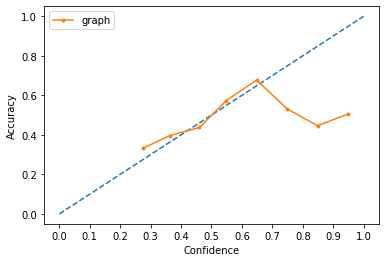

In [30]:
    for i in [70,80]:
        pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
        checkpoints = torch.load(pretrain_model)
        model.load_state_dict(checkpoints['state_dict'])
    
        # use cpu or cuda
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
    
        evaluate(args, model,seq, device, "D12", str(i), plot=True) 